In [ ]:
import json
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

### **Download data**

In [ ]:
with open('boxplot_results.json', 'r') as file:
    data = json.load(file)

In [ ]:
# Initialize an empty list to store data
df_data = []

# Iterate over the keys in the JSON data to extract the values and create rows for the DataFrame
for key, values in data.items():
    parts = key.split('_')
    model = int(parts[1][-1])  # Extract the model number
    s = int(parts[-1])  # Extract the set number
    for gain in values:
        df_data.append([model, s, gain])

# Create a DataFrame from the list of data
df = pd.DataFrame(df_data, columns=["Model", "Set", "Gain"])

In [ ]:
df.head()

,Model,Set,Gain
0,1,1,-245.6
1,1,1,-225.4
2,1,1,-225.4
3,1,1,-91.6
4,1,1,-225.4


### **Two-way ANOVA test**

**Null Hypothesis (H0):** There is no significant difference between the groups of the independent variable Model in relation to the dependent variable Gain.

*(any observed variations in the data are purely due to random sampling variability or chance)*


**Alternative Hypothesis (H1):** There is a significant difference between the groups of the independent variable Model in relation to the dependent variable Gain.

*(observed variations in the data are not merely due to random chance but are the result of a genuine effect or relationship)*

In [ ]:
formula = 'Gain ~ C(Model) + C(Set) + C(Model):C(Set)'
model = ols(formula, data=df).fit()
result = sm.stats.anova_lm(model, type=2)

# Print the result
print(result.round(4))

                   df      sum_sq      mean_sq        F  PR(>F)
C(Model)          1.0     846.400     846.4000   0.1327  0.7178
C(Set)            1.0  141562.404  141562.4040  22.1975  0.0000
C(Model):C(Set)   1.0    5134.756    5134.7560   0.8051  0.3755
Residual         36.0  229586.664    6377.4073      NaN     NaN


* Model*Set: 0.376 > 0.05 => not statistically significant => remove intersection

In [ ]:
formula = 'Gain ~ C(Model) + C(Set)'
model = ols(formula, data=df).fit()
result = sm.stats.anova_lm(model, type=2)

# Print the result
print(result)
print("Coeff:\n" + str(model.params))

            df      sum_sq        mean_sq          F    PR(>F)
C(Model)   1.0     846.400     846.400000   0.133421  0.716991
C(Set)     1.0  141562.404  141562.404000  22.315002  0.000033
Residual  37.0  234721.420    6343.822162        NaN       NaN
Coeff:
Intercept       -222.97
C(Model)[T.2]      9.20
C(Set)[T.2]      118.98
dtype: float64


* **Model: 0.717 > 0.05 => factor Model does not have a statistically significant effect on Gain / There is no significant difference between the groups of the independent variable Model in relation to the dependent variable Gain.**

* Set: ~0 < 0.05 => factor Set has a statistically significant effect on Gain / There is significant difference between the groups of the independent variable Set in relation to the dependent variable Gain.

**=> the effect of Model is not consistent across all Sets of enemies (All group means are not equal at each level of the Set)**

& the effect of Set is consistent across all Models (All group means are equal at each level of the Model)

### **One-way ANOVA tests for 2 sets of enemies separately**

In [ ]:
for i in [1, 2]:
  mod = ols('Gain ~ Model', data=df[df['Set'] == i]).fit()
  res = sm.stats.anova_lm(mod, type=2)
  print("-"*26 + " Set " + str(i) + " " + "-"*27)
  print(res)
  print("Coeff for Model: " + str(mod.params.Model.round(4)))

-------------------------- Set 1 ---------------------------
            df     sum_sq      mean_sq         F    PR(>F)
Model      1.0    905.858   905.858000  0.725713  0.405468
Residual  18.0  22468.164  1248.231333       NaN       NaN
Coeff for Model: -13.46
-------------------------- Set 2 ---------------------------
            df      sum_sq       mean_sq         F    PR(>F)
Model      1.0    5075.298   5075.298000  0.441078  0.515021
Residual  18.0  207118.500  11506.583333       NaN       NaN
Coeff for Model: 31.86


Two one-way ANOVA tests were also conducted to determine the effect of algorithm choice (with and without adaptive alpha) on average gain for each set of enemies separately.

The results indicate that the differences between the two algorithms are not statistically significant for Set 1 which contains enemies 2, 5 (p-value = 0.4055).

Analogously, our experiment also showed that we don’t have sufficient evidence to say that there is a statistically significant difference between the two tested algorithms for the 2nd set of enemies (2, 4, 6, 7) (p-value = 0.515).

### **Boxplots (not used in the report)**

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def get_values(df, iv, dv, mean_only=False):
  for i in sorted(df[iv].unique()):
    dataset = df.loc[df[iv] == i][dv]
    print(f"Mean {dv} for {iv} {i}: {round(dataset.mean(), 2)}")
    if not mean_only:
      print(f"Median {dv} for {iv} {i}: {round(dataset.median(), 2)}")
      print(f"Q1 {dv} for {iv} {i}: {round(dataset.quantile(0.25), 2)}")
      print(f"Q3 {dv} for {iv} {i}: {round(dataset.quantile(0.75), 2)}")

In [ ]:
def plot_boxplot(df, column, group, ylabel, xlabel, title, color):

  bplt = df.boxplot(column=column, by=group, color=color,
                              grid=False, figsize=(8,5))

  fig = bplt.get_figure()
  fig.suptitle('')
  bplt.set_ylabel(ylabel)
  bplt.set_xlabel(xlabel)
  plt.title(title)
  plt.show()
  return bplt

In [ ]:
colors = [{"boxes": "#5D62A7", "whiskers": "#35B2AA", "medians": "#F79B25"},
          {"boxes": "#6F5C87", "whiskers": "#879E6F", "medians": "#F79B25"}]

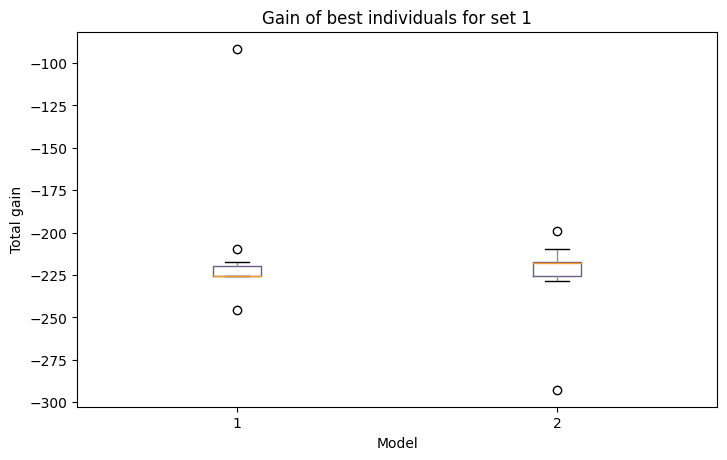

In [ ]:
boxplot1 = plot_boxplot(df[df['Set'] == 1], "Gain", "Model", "Total gain",
                        "Model", "Gain of best individuals for set 1", colors[1])

In [ ]:
get_values(df[df['Set'] == 1], 'Model', 'Gain', mean_only=False)

Mean Gain for Model 1: -211.64
Median Gain for Model 1: -225.4
Q1 Gain for Model 1: -225.4
Q3 Gain for Model 1: -219.4
Mean Gain for Model 2: -225.1
Median Gain for Model 2: -217.9
Q1 Gain for Model 2: -225.4
Q3 Gain for Model 2: -217.4


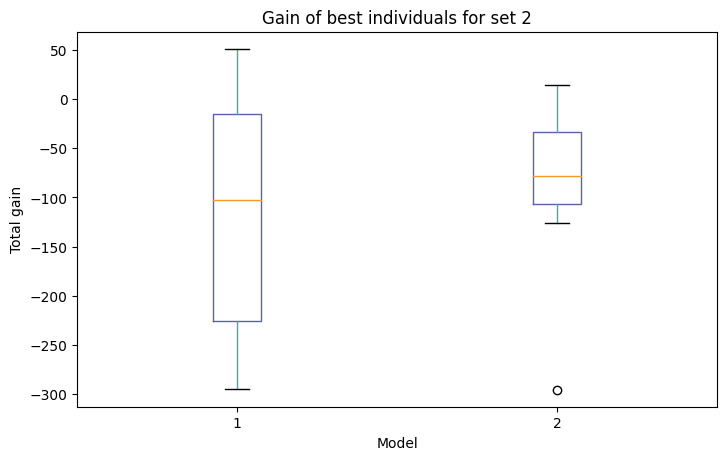

In [ ]:
boxplot2 = plot_boxplot(df[df['Set'] == 2], "Gain", "Model", "Total gain",
                        "Model", "Gain of best individuals for set 2", colors[0])

In [ ]:
get_values(df[df['Set'] == 2], 'Model', 'Gain', mean_only=False)

Mean Gain for Model 1: -115.32
Median Gain for Model 1: -102.5
Q1 Gain for Model 1: -225.4
Q3 Gain for Model 1: -14.85
Mean Gain for Model 2: -83.46
Median Gain for Model 2: -78.5
Q1 Gain for Model 2: -106.35
Q3 Gain for Model 2: -33.5
